In [1]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 33.8 MB/s eta 0:00:00


In [2]:
import sys
import os

def is_colab_env():
    return "google.colab" in sys.modules

def mount_google_drive(drive_dir="/content/drive/", repo_dir="MyDrive/repositories/deepfake-detection"):
    # mount google drive
    from google.colab import drive
    drive.mount(drive_dir)

    # change to correct working directory
    import os
    repo_dir = f"{drive_dir}{repo_dir}"
    os.chdir(repo_dir)
    print(os.listdir()) # verify content
    return repo_dir

def resolve_path(levels_deep=3):
    if is_colab_env():
        return mount_google_drive()
    else:
        # Get the directory of the current script
        current_dir = os.path.dirname(os.path.abspath('__file__'))

        # Construct the path to the parent directory
        for i in range(levels_deep):
            current_dir = os.path.dirname(current_dir)

        # Add the parent directory to sys.path
        sys.path.append(current_dir)
        print(sys.path)
        return current_dir

proj_dir = resolve_path(2)

Mounted at /content/drive/
['src', '.git', 'playground', 'setup', 'README.md', 'environment.yml', 'environment-updated.yml', 'hf_wdf.sh', 'run_jupyter.sh', '.gitignore', 'freqnet_image.ipynb', 'config.py', 'reports', '__pycache__', 'faceforensics_download.py']


In [3]:
# import local config
import config

In [4]:
# from src.adapters.datasets.wilddeepfake import load_streaming_dataset
from datasets import load_dataset

In [5]:
import torch

In [6]:
from src.transforms.frequency import fft_amp_phase

In [7]:
dataset = load_dataset("xingjunm/WildDeepfake", streaming=True, split="test")

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/963 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/157 [00:00<?, ?it/s]

In [8]:
from tqdm import tqdm

In [9]:
import numpy as np

real_fft_mean = np.zeros((2, 224, 224))
fake_fft_mean = np.zeros((2, 224, 224))
real_count = 0
fake_count = 0

pbar = tqdm(total=165662)

for d in dataset:
    img = d['png']
    fft_result = fft_amp_phase(img)  # Returns a NumPy array
    fft_result = fft_result.detach().cpu().numpy()


    if "real" in d["__key__"]:
        real_count += 1
        real_fft_mean += (fft_result - real_fft_mean) / real_count
    else:
        fake_count += 1
        fake_fft_mean += (fft_result - fake_fft_mean) / fake_count


    pbar.update(1)

100%|█████████▉| 165656/165662 [33:40<00:00, 80.49it/s]

In [10]:
print("Real samples:", real_count)
print("Fake samples:", fake_count)

Real samples: 58659
Fake samples: 107003


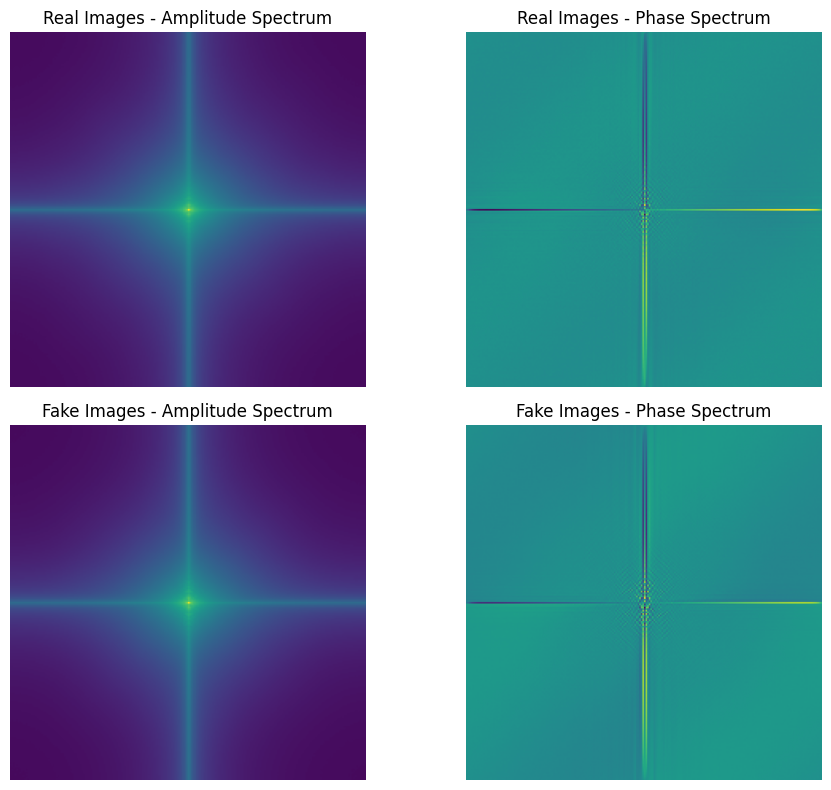

In [11]:
import matplotlib.pyplot as plt

# mean_real_fft and mean_fake_fft have shape (2, H, W)
mean_real_amp = real_fft_mean[0]      # Real part for real images
mean_real_phase = real_fft_mean[1]      # Imaginary part for real images
mean_fake_amp = fake_fft_mean[0]      # Real part for fake images
mean_fake_phase = fake_fft_mean[1]      # Imaginary part for fake images

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(mean_real_amp)
axs[0, 0].set_title('Real Images - Amplitude Spectrum')
axs[0, 1].imshow(mean_real_phase)
axs[0, 1].set_title('Real Images - Phase Spectrum')
axs[1, 0].imshow(mean_fake_amp)
axs[1, 0].set_title('Fake Images - Amplitude Spectrum')
axs[1, 1].imshow(mean_fake_phase)
axs[1, 1].set_title('Fake Images - Phase Spectrum')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()